#  Track Your Tinnitus (TYT) Dataset

## Purpose of this Notebook
- [x] Get an statistical overview
    - [x] How many users?
    - [x] How many assessments (= filled out questionnaires)?
    - [x] Date range of the dataset?
    - [x] User-assessment distribution
    - [x] Baseline statistics (Sex and Age)
    


## Preparation
Import modules and load data for later use

In [1]:
# imports
import pandas as pd
from datetime import date, datetime
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# local imports
import sys
sys.path.insert(0, "../..")

from src.d00_utils import helpers, process_tyt_dataset

In [3]:
# read data
tyt_all = pd.read_csv("../../data/d01_raw/tyt/22-10-24_standardanswers.csv")
KEEP_COLUMNS = ['user_id','created_at','question1','question2','question3','question4','question5','question6','question7']
tyt_raw = tyt_all[KEEP_COLUMNS]
tyt_raw.loc[:,'created_at'] = pd.to_datetime(tyt_raw.created_at, format="%Y-%m-%d %H:%M:%S")
tyt_raw.head()

,user_id,created_at,question1,question2,question3,question4,question5,question6,question7
0,NaN,2013-07-18 14:14:32,0.0,0.0,0.170818,0.666667,0.25,0.241993,0.343416
1,NaN,2013-07-18 14:14:34,0.0,0.0,0.170818,0.666667,0.25,0.241993,0.343416
2,NaN,2013-07-18 14:14:35,0.0,0.0,0.170818,0.666667,0.25,0.241993,0.343416
3,NaN,2013-07-18 14:14:35,0.0,0.0,0.170818,0.666667,0.25,0.241993,0.343416
4,NaN,2013-07-26 07:40:23,0.0,0.0,0.170818,0.666667,0.25,0.241993,0.343416


In [4]:
tyt_all.head()

,Unnamed: 0,id,user_id,question1,question2,question3,question4,question5,question6,question7,question8,soundlevel,save_date,notification_date,autosaved,notification_fixed,created_at,updated_at,user_agent,user_id_reference
0,0,92,NaN,0.0,0.0,0.170818,0.666667,0.25,0.241993,0.343416,NaN,0.0,2013-07-15 20:48:00,NaN,NaN,NaN,2013-07-18 14:14:32,2013-07-18 14:14:32,NaN,NaN
1,1,93,NaN,0.0,0.0,0.170818,0.666667,0.25,0.241993,0.343416,NaN,0.0,2013-07-15 20:48:00,NaN,NaN,NaN,2013-07-18 14:14:34,2013-07-18 14:14:34,NaN,NaN
2,2,94,NaN,0.0,0.0,0.170818,0.666667,0.25,0.241993,0.343416,NaN,0.0,2013-07-15 20:48:00,NaN,NaN,NaN,2013-07-18 14:14:35,2013-07-18 14:14:35,NaN,NaN
3,3,95,NaN,0.0,0.0,0.170818,0.666667,0.25,0.241993,0.343416,NaN,0.0,2013-07-15 20:48:00,NaN,NaN,NaN,2013-07-18 14:14:35,2013-07-18 14:14:35,NaN,NaN
4,4,395,NaN,0.0,0.0,0.170818,0.666667,0.25,0.241993,0.343416,NaN,0.0,2013-07-15 20:48:00,NaN,NaN,NaN,2013-07-26 07:40:23,2013-07-26 07:40:23,NaN,NaN


## Statistical overview
Here we calculate statistics for both the dataset overall and the baseline questionaires

In [5]:
result = dict()

### Number of users

In [6]:
print('Number of user:\t', tyt_all.user_id.nunique())
result['n_users'] = tyt_all.user_id.nunique()

Number of user:	 3303


### Number of assessments

In [7]:
print('Number of assessments:\t', tyt_all.id.nunique())
result['n_assessments'] = tyt_all.id.nunique()

Number of assessments:	 110983


### Date Range of assessments

In [8]:
result['First assessment from'] = tyt_raw.created_at.min().date()
result['Latest assessment from'] = tyt_raw.created_at.max().date()

print("Start:\t", tyt_raw.created_at.min().date())
print("End:\t", tyt_raw.created_at.max().date())

delta = (tyt_raw.created_at.max() - tyt_raw.created_at.min())

print('\nDate Range in')
print('Years:\t', delta.days/365)
print('Months:\t', delta.days/12)
print('Days:\t', delta.days)

result['Time range in days'] = delta.days

Start:	 2013-07-18
End:	 2022-09-30

Date Range in
Years:	 9.205479452054794
Months:	 280.0
Days:	 3360


### Schedule pattern

In [9]:
tyt_raw.created_at

0        2013-07-18 14:14:32
1        2013-07-18 14:14:34
2        2013-07-18 14:14:35
3        2013-07-18 14:14:35
4        2013-07-26 07:40:23
                 ...        
110978   2022-09-30 04:58:13
110979   2022-09-30 05:30:31
110980   2022-09-30 07:33:48
110981   2022-09-30 07:41:35
110982   2022-09-30 12:12:40
Name: created_at, Length: 110983, dtype: datetime64[ns]

In [10]:
tyt_copy = tyt_raw.copy()
tyt_copy.created_at = tyt_raw.created_at.dt.strftime('%Y-%m-%d %H:%M:%S')
res = helpers.find_schedule_pattern(tyt_copy)
result.update(res)
res

{'Median hours between two assessments': 11.246527777777779,
 'Median days between two assessments': 0.46860532407407407,
 'std_hours': 1003.5619887715163,
 'std_days': 41.81508286547985}

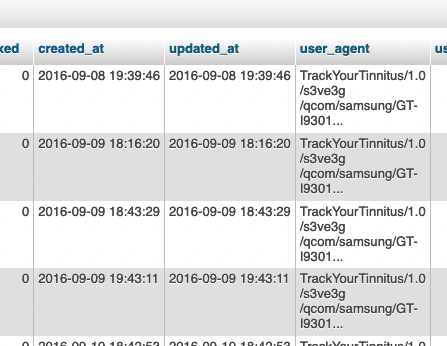

Note: Although it's a daily questionnaire, the questionnaire can be filled out more than once per day. Here an example of userid `2427` of the database.

### Distribution of filled out questionnaires

In [11]:
bins = [0, 1, 2, 3, 5, 10, 100, 1000, 10000]

ser = pd.cut(tyt_raw.user_id.value_counts(), bins = bins).value_counts().sort_index()
print(ser)
result.update(dict(ser))

(0, 1]           1017
(1, 2]            456
(2, 3]            266
(3, 5]            280
(5, 10]           294
(10, 100]         768
(100, 1000]       209
(1000, 10000]      13
Name: user_id, dtype: int64


As you can see, unlike the UNITI dataset, the TYT dataset shows a much more sharp drop-off curve for how long users last before they give up...
This is probably due to the fact that most UNITI App users are recruited by doctors for the UNITI RCT

### What about at the user level?

In [12]:
tyt_raw['date'] = tyt_raw['created_at'].map(lambda x: x.date())
tyt_interaction_intensity_userlevel = pd.DataFrame(tyt_raw.groupby('user_id').agg({'date':['min','max','nunique'], 'user_id':'count'}).reset_index().values, columns = ['user_id','date_min','date_max','n_unique_days', 'n_assessments'])
tyt_interaction_intensity_userlevel['date_min'] = pd.to_datetime(tyt_interaction_intensity_userlevel.date_min, format='%Y-%m-%d')
tyt_interaction_intensity_userlevel['date_max'] = pd.to_datetime(tyt_interaction_intensity_userlevel.date_max, format='%Y-%m-%d')
tyt_interaction_intensity_userlevel['n_unique_days'] = tyt_interaction_intensity_userlevel['n_unique_days'].astype(int)
tyt_interaction_intensity_userlevel['n_assessments'] = tyt_interaction_intensity_userlevel['n_assessments'].astype(int)
tyt_interaction_desc = tyt_interaction_intensity_userlevel.describe(datetime_is_numeric=True)

In [13]:
print("Min. number of unique days of data from a user is:", tyt_interaction_desc['n_unique_days']['min'],
      "days \n25% of the users have <=",tyt_interaction_desc['n_unique_days']['25%'],
      "days \n50% of the users have <=",tyt_interaction_desc['n_unique_days']['50%'],
      "days \n75% of the users have <=",tyt_interaction_desc['n_unique_days']['75%'],
      "days, and \nMax. number of unique days of data from a user is:",tyt_interaction_desc['n_unique_days']['max'])

Min. number of unique days of data from a user is: 1.0 days 
25% of the users have <= 1.0 days 
50% of the users have <= 2.0 days 
75% of the users have <= 8.0 days, and 
Max. number of unique days of data from a user is: 1849.0


In [14]:
print("Min. number of submitted assessments from a user is:", tyt_interaction_desc['n_assessments']['min'],
      "assessments \n25% of the users have <=",tyt_interaction_desc['n_assessments']['25%'],
      "assessments \n50% of the users have <=",tyt_interaction_desc['n_assessments']['50%'],
      "assessments \n75% of the users have <=",tyt_interaction_desc['n_assessments']['75%'],
      "assessments, and \nMax. number of submitted assessments from a user is:",tyt_interaction_desc['n_assessments']['max'])

Min. number of submitted assessments from a user is: 1.0 assessments 
25% of the users have <= 1.0 assessments 
50% of the users have <= 3.0 assessments 
75% of the users have <= 16.0 assessments, and 
Max. number of submitted assessments from a user is: 6815.0


### Results

In [15]:
result

{'n_users': 3303,
 'n_assessments': 110983,
 'First assessment from': datetime.date(2013, 7, 18),
 'Latest assessment from': datetime.date(2022, 9, 30),
 'Time range in days': 3360,
 'Median hours between two assessments': 11.246527777777779,
 'Median days between two assessments': 0.46860532407407407,
 'std_hours': 1003.5619887715163,
 'std_days': 41.81508286547985,
 Interval(0, 1, closed='right'): 1017,
 Interval(1, 2, closed='right'): 456,
 Interval(2, 3, closed='right'): 266,
 Interval(3, 5, closed='right'): 280,
 Interval(5, 10, closed='right'): 294,
 Interval(10, 100, closed='right'): 768,
 Interval(100, 1000, closed='right'): 209,
 Interval(1000, 10000, closed='right'): 13}

## Pointers for Target variable

###  A candidate for target variable (Regression) is "question3"
This is because it is a measure of the distress caused by the disease, and because there is no clear treatment that reliably reduces symptom severity, treating the distress caused by the disease (like in the case of chronic pain) is considered the thing to do, rather than treat the symptom severity.

###  If classification, target variable ("question3") discretisation can be attempted:
(target in mean +/- user-defined noise threshold is "no change",
target > mean + threashold is "worse",
mean - threshold is "better")

### Candidate for features is all other questions excluding target:

[question1,question2,question4,question5,question6, question7]

###  Misc. tips

#### It might be useful to exclude the single binary variable question 1, which asks if the user hears tinnitus right now. It is observed that users are filling loudness and distress as nonzero even when they answer question 1 as "NO".

For example, see below a comparison of the values for the other 6 questions when NO was the answer to question1.

The table below that shows, however, that the values for these 6 questions are much lower than usual... So, this decision is a bit complicated.... But it is possible to argue for either decision (include / exclude this var)

In [16]:
tyt_raw[tyt_raw.question1 == 0].drop('user_id', axis=1).describe()

,question1,question2,question3,question4,question5,question6,question7
count,22184.0,20867.000000,20753.000000,21679.000000,21583.000000,21053.000000,21153.000000
mean,0.0,0.248225,0.187638,0.614473,0.263132,0.214860,0.590614
std,0.0,0.245586,0.203526,0.191691,0.226620,0.205620,0.312521
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.050000,0.030000,0.500000,0.120000,0.050000,0.330000
50%,0.0,0.172794,0.125000,0.620000,0.250000,0.161765,0.630000
75%,0.0,0.378676,0.272059,0.750000,0.375000,0.316177,0.870000
max,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
tyt_raw[tyt_raw.question1 != 0].drop('user_id', axis=1).describe()

,question1,question2,question3,question4,question5,question6,question7
count,87160.0,88161.000000,82311.000000,86477.000000,85133.000000,80979.000000,84686.000000
mean,1.0,0.532222,0.418216,0.541280,0.236760,0.291427,0.591452
std,0.0,0.302344,0.286249,0.214534,0.223614,0.245846,0.320795
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,0.280000,0.183823,0.500000,0.000000,0.090000,0.320000
50%,1.0,0.510000,0.378677,0.500000,0.250000,0.240000,0.610000
75%,1.0,0.790000,0.630000,0.750000,0.370000,0.433824,0.913603
max,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Baseline information

In [18]:
df = pd.read_csv('../../data/d01_raw/tyt/22-10-24_answers.csv', index_col='id', na_values=['??.??.????'])

In [19]:
users_list = tyt_raw.user_id.dropna().unique()

In [20]:
def calculate_ages(users_list):
    """
    Calculates the ages of a given user list for the TYT dataset
    """

    user_filt = df.user_id.isin(users_list) # selects all users that are in the used dataset
    q_filt = df.question_id==4 # filters for question "Whats your birthdate?"

    dobs = df[(user_filt) & (q_filt)].answer # date of births = dobs
    yobs = pd.to_datetime(dobs, format='%d.%m.%Y', errors='coerce')# year of births

    df.created_at = pd.to_datetime(df.created_at)
    timedelta = df.loc[yobs.index, 'created_at'] - yobs
    ages = timedelta.dt.days/365.25

    return ages

### Age distribution

In [21]:
ages = calculate_ages(users_list)
print('Ages Mean:\t', ages.mean())
print('Ages Std:\t', ages.std())

Ages Mean:	 45.02832322905444
Ages Std:	 14.42746611499237


### Sex distribution

In [22]:
user_filt = df.user_id.isin(users_list) # selects all users that are in the used dataset
q_filt = df.question_id==5 # filters for question "Whats your gender?"

sex_s = df[(user_filt) & (q_filt)].answer # date of births = dobs

In [23]:
sex_s.value_counts(normalize=True)

Male      0.670462
Female    0.329538
Name: answer, dtype: float64